In [ ]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


# 1. Local Outlier Factor
This first part of the assignment will consist of implementing the LOF from the ground up.

First, we need a dataset to work with, which is created below.

In [ ]:
data, labels = make_blobs(n_samples=[100, 100, 2],random_state=42)
#data, labels = make_blobs(n_samples=[3, 3, 2],random_state=42)

## Task: Understand the dataset
1. Shortly describe the dataset, and what you would expect the LOF to be of the different datapoints

## Answer
- By looking at the scatter plot, there are two clusters where the LOF for each point should be small, but there are also a couple of local ouliers for which the LOF should be greater.
Also there are two global outlier points, for those the LOF should be very large.

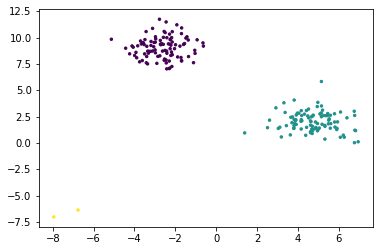

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, s=6)

## Task: implement the Local Outlier Factor
- Below are the signatures of all functions necessary for the Local Outlier Factor. Complete the implementations to fully implement the LOF.

In [ ]:

def dist(x, y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)


In [ ]:
def k_dist(k, o, D):
    distances=[]
    for p in D:
       distances.append(dist(o,p))
    distances.sort()
    return distances[k]




In [ ]:
def N_k(k, o, D):
    k_d = k_dist(k,o,D)
    neighbours = []
    for p in D:
      if(not (p==o).all()):
        if(dist(o,p)<= k_d):
          neighbours.append(p)

    return neighbours

print(data[0])
print(N_k(1,data[0],data))

[4.64512254 2.02015028]
[array([4.61897724, 2.09049707])]


In [ ]:
def reach_dist(k, x, o, D):
    return max(k_dist(k,o,D),dist(o,x))

In [ ]:
def lrd(k, o, D):
    avg_reach_dist = 0
    for n in N_k(k,o,D):
      avg_reach_dist+= reach_dist(k,o,n,D)

    return (avg_reach_dist/k)**(-1)

In [ ]:
def lof(k, o, D):
  lof=0
  lrd_o=lrd(k,o,D)
  for x in N_k(k,o,D):
    lof+= lrd(k,x,D)/lrd_o

  return lof/k

### Below is some helper code so you can compare your results with the LOF of the popular library scikit-learn

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
# it should work for all values of k of course
k = 5

In [ ]:
my_lof_scores = np.array([lof(k, o, data) for o in data])
print(my_lof_scores[:10])

[1.03854434 1.03759892 0.94794951 1.09736105 0.98664123 1.74905378
 1.03064327 1.04210801 2.1033075  0.9904549 ]


In [ ]:
sk_lof = LocalOutlierFactor(n_neighbors=k)
sk_lof.fit_predict(data)
sk_lof_scores = np.negative(sk_lof.negative_outlier_factor_)
print(sk_lof_scores[:10])

[1.03854434 1.03759892 0.94794951 1.09736105 0.98664123 1.74905378
 1.03064327 1.04210801 2.1033075  0.9904549 ]


In [ ]:
# the real test: check if the LOF scores are the same
np.allclose(my_lof_scores, sk_lof_scores, rtol=0, atol=1e-8)

True

## Visualizing your LOF.
Below is your LOF calculation visualized for the dataset.

2. Is this what you expected for the LOF scores?
3. Describe in text / figures which points you consider anomalies and why?

## Answer
- 2. Yes

- 3. From the scatter plot, the points with the bigger circles around them compared to the neighbours are the potential anomalies. By looking at the LOF values, points with LOF > 1 are potential outliers.
In the following scatterplot I marked red the points with LOF > 2

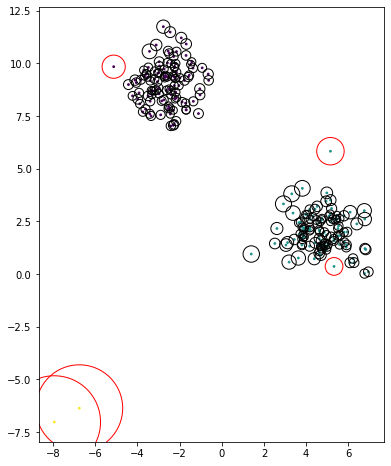

In [ ]:
f, ax = plt.subplots(figsize=(14, 8))
ax.scatter(data[:,0], data[:,1], c=labels, s=3)
ax.set_aspect(1)
for i in range(len(my_lof_scores)):
    if(my_lof_scores[i]>2):
      ax.add_artist(plt.Circle(tuple(data[i]), my_lof_scores[i] / 5 , fill = False,color='r'))
    else:
      ax.add_artist(plt.Circle(tuple(data[i]), my_lof_scores[i] / 5 , fill = False))

# 2. Isolation Forest
Next we will implement the Isolation Forest.

Again, we will use a dataset, which is created below.

In [ ]:
rng = np.random.default_rng(seed=42)

# data to build forest on
data = rng.normal(loc=[2, 5, 2, 5], scale=2, size=[400, 4])
outliers = rng.normal(loc=[2, 0, 2, 0], scale=2, size=[10, 4])

# data to test with
testdata = np.vstack((rng.normal(loc=[2, 5, 2, 5], scale=2, size=[200, 4]),
                     rng.normal(loc=[2, 0, 2, 0], scale=2, size=[20, 4])))

test_labels = np.concatenate((np.full(200,0),np.full(20,1)))
print(test_labels.shape)

#print(data)
#print(len(data[0]))
#d = data[:,0]
#data[data[:,0]<-1]




(220,)


## Implementing
Below is some skeleton code which is left for you to implement the isolation forest

In [ ]:
class iTree:
    def __init__(self, D, e, l):
        """
        constructs an isolation tree given the input parameters:

        :D: is the dataset
        :e: is the current path length
        :l: is the maximum path length
        """
        self.D=D
        self.e=e
        self.l=l

        #print("e",e)
        #print("D",D)
        if(self.e<self.l and len(D)>1):

          self.f = random.randint(0,len(D[0])-1)
          data=D[:,self.f]
          min = np.min(data)
          max = np.max(data)
          self.split = random.uniform(min,max)
          #print("f",self.f)
          #print("split",self.split)

          #print("left")
          self.left = iTree(D[D[:,self.f]<self.split],e+1,l)
          #print("right")
          self.right = iTree(D[D[:,self.f]>=self.split],e+1,l)


    def test(self, o, pl = 0):
        """
        test the datapoint :o: against this tree, returns the path length
        """
        if(len(self.D)>1 and pl<self.l ):
          if(o[self.f]<self.split):
              pl = self.left.test(o,pl+1)
          if(o[self.f]>=self.split):
              pl = self.right.test(o,pl+1)

        return pl


In [ ]:
d=np.array([[1,2],[2,1],[3,3]])
tree = iTree(d,0,5)

print("test:",tree.test([1,2],0))
print("test:",tree.test([10,10],0))


test: 2
test: 1


In [ ]:
class iForest:
    def __init__(self, D, t, phi):
        """
        Constructs an Isolation Forest given the input parameters:

        :D: the dataset
        :t: number of isolation trees
        :phi: size of subset to take from D
        """

        self.trees=[]
        for i in range(t):
          subset = D[np.random.choice(D.shape[0], size=phi, replace=False)]
          self.trees.append(iTree(subset,0, np.log2(phi)))


    def test(self, o):
        """
        Tests the given datapoint :o: on the isolation trees and returns the average path length.
        """
        avg=0
        for tree in self.trees:
          avg += tree.test(o)

        return avg/len(self.trees)

## Tainted vs. Untainted Datasets
- Build the isolation forest on both the untainted and the tainted dataset (for the tainted dataset just combine the data and outliers, don't use the test data)
- Plot the ROC curves for both isolation forests. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html for a function to calculate the ROC curve. Note that we take anomalies as the positive class.
1. Does it significantly affect the performance of the isolation forest? Shortly explain why it does or it doesn't.
2. A nice property of the isolation forest is that we can use subsampling without degradation in performance. How does subsampling help with masking?

## Answer
- 1. Yes, tainted dataset might affect the performace by modifying the structures of the trees, and causing outliers to take longer paths.

- 2. Using subsampling the outliers in a tainted dataset are less likely to to be selected, improving the overall structures of the trees and the accuracy of the model.

In [ ]:
from sklearn.metrics import roc_curve

def roc_plot(test_labels,scores):
  fpr, tpr, thresholds = roc_curve(test_labels, scores, pos_label=0)
  plt.plot(fpr,tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()
  optimal_idx = np.argmax(tpr - fpr) #high tpr, low fpr
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal Threshold:", optimal_threshold)
  return optimal_threshold

UNTAINTED


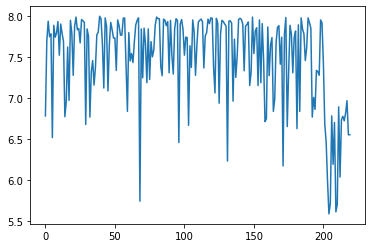

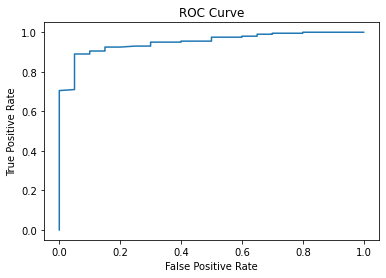

Optimal Threshold: 6.975
TAINTED


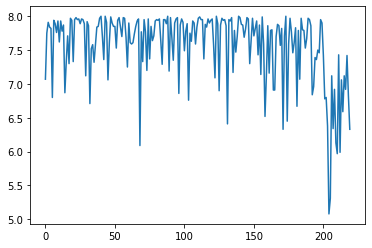

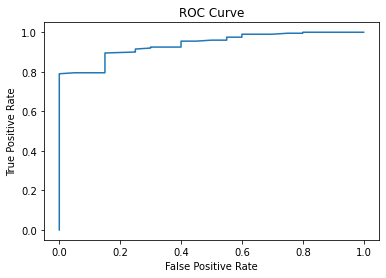

Optimal Threshold: 7.46


In [ ]:

print("UNTAINTED")
phi=data.shape[0]//2 #//2 //5 //10 //20
forest = iForest(data,200,phi)

lengths=[]
for p in testdata:
  lengths.append(forest.test(p))

plt.plot(lengths)
plt.show()

optimal_threashold=roc_plot(test_labels,lengths)

print("TAINTED")

forest_tainted = iForest(np.vstack((data,outliers)),100,phi)

lengths=[]
for p in testdata:
  lengths.append(forest_tainted.test(p))

plt.plot(lengths)
plt.show()

optimal_threashold_tainted=roc_plot(test_labels,lengths)

## Task: Understanding the hyperparameters
3. Play around with the hyperparameters. How small / large can you subsample before your performance starts to decrease? Why? How many trees do you need in the forest?

## Answer
- Using 20-50% of subsampling is ok.

- 100 trees is ok. But with higher subsampling it might be better to use more trees to make sure all points of the dataset are used

## Task: Building a detector
We now have an isolation forest which can give a measure of anomalousness for a given datapoint. But how are we going to use it to detect anomalies?

4. Using a threshold, create a detector which given a datapoint indicates whether it is anomalous or not. It should return a 1 if it is an anomaly, and a 0 if it is normal data.
    - NOTE: Motivate why you choose your threshold using metrics
    
## Answer
- Sklearn tries different thresholds to compute the roc curve, so I used the threshold where the tpr is higher and fpr is lower: tpr-fpr

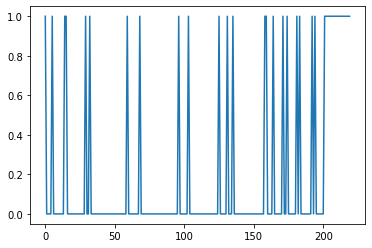

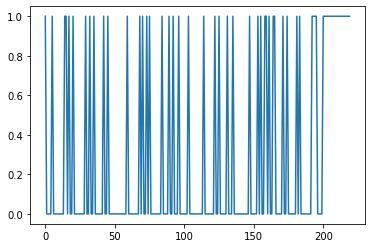

In [ ]:
def detect(datapoint, iforest, threshold):
    """
    Returns 1 if the given datapoint is an anomaly, 0 otherwise.
    """
    if(iforest.test(datapoint)<threshold):
      return 1
    return 0

predictions=[]
for p in testdata:
  predictions.append(detect(p,forest,optimal_threashold))

plt.plot(predictions)
plt.show()

predictions_tainted=[]
for p in testdata:
  predictions_tainted.append(detect(p,forest_tainted,optimal_threashold_tainted))

plt.plot(predictions_tainted)
plt.show()

## Task: Evaluate
Now we want to evaluate the performance of your detector.
- Calculate the True Positive Rate, False Positive Rate, and Precision for your detector based on the output of the confusion matrix. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix for how to use the function, and see https://en.wikipedia.org/wiki/Confusion_matrix for how to calculate the metrics.
   - NOTE: do NOT use some other convenience function from sklearn or elsewhere to calculate these metrics. These may only be used to validate your metrics.

5. Are you happy with the performance of the model? Why or why not?

## Answer
- Yes. Precision is not great, meaning that some points will be misclassified as anomalies. But tpr is very high, so true anomalies will be detected.

UNTAINTED
[[178  22]
 [  1  19]]


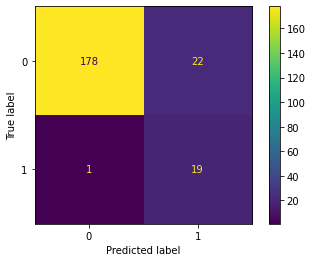

Precision= 0.4634146341463415
tpr= 0.95
fpr 0.11
TAINTED
[[158  42]
 [  0  20]]


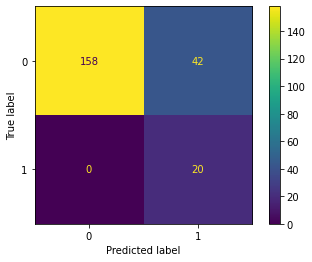

Precision= 0.3225806451612903
tpr= 1.0
fpr 0.21


In [ ]:

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def precision(tp,fp):
  return tp/(tp+fp)

def tpr(tp,fn):
  return tp/(tp+fn)

def fpr(fp,tn):
  return fp/(fp+tn)

cm = confusion_matrix(test_labels, predictions)

print("UNTAINTED")
print(cm)


cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cm_display.plot()
plt.show()

"""
TN | FP
FN | TP
"""
tn=cm[0][0]
fp=cm[0][1]
fn=cm[1][0]
tp=cm[1][1]

print("Precision=", precision(tp,fp))
print("tpr=", tpr(tp,fn))
print("fpr", fpr(fp,tn))

cm = confusion_matrix(test_labels, predictions_tainted)

print("TAINTED")
print(cm)


cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cm_display.plot()
plt.show()

tn=cm[0][0]
fp=cm[0][1]
fn=cm[1][0]
tp=cm[1][1]

print("Precision=", precision(tp,fp))
print("tpr=", tpr(tp,fn))
print("fpr", fpr(fp,tn))

# 3. Machine Learning for Temporal Anomaly Detection
We will now look at the case of temporal data. For temporal data, it is possible to use any conventional Machine Learning model in order to perform anomaly detection. We start by creating a simple dataset below. We inject an anomaly towards the end of the dataset which will be included in the test dataset.

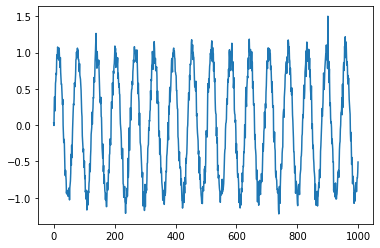

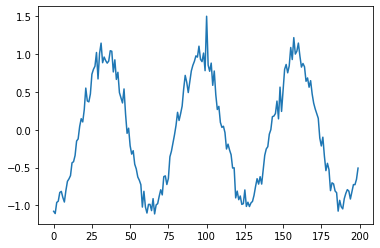

In [ ]:
rng = np.random.default_rng(seed=42)
y = np.sin(np.arange(0, 100, 0.1)) + rng.normal(loc=0, scale=0.1, size=1000)
y[900] = 1.5
train = y[:800]
test = y[800:]
plt.plot(y)
plt.show()
plt.plot(test)

## Question
I have created this simple dataset by using a sine function and adding some gaussian-distributed noise.
1. Is this training dataset tainted or untainted? Explain why or why not.

## Answer
- No it is not tainted, there is just some noise added uniformly to the whole dataset.


## Task: Set up the training
We will use a ML algorithm with a sliding window to try and predict the next value based on the last 24.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take the last 24 datapoints (X) to predict the next datapoint (Y)

In [ ]:
train_x = []
train_y = []

window_size=25
stride=1
#for i in range(0,len(train),window_size):
for i in range(0,len(train)-window_size+1,stride):
      train_x.append(train[i:i+window_size-1])
      train_y.append(train[i+window_size-1])
      #print(i+window_size-1)

print(train[:25])
print(train_x[0])
print(train_y[0])

test_x = []
test_y = []

for i in range(0,len(test)-window_size+1,stride):
      test_x.append(test[i:i+window_size-1])
      test_y.append(test[i+window_size-1])

print(len(test))
print(len(test_x))
print(len(test_y))


[ 0.03047171 -0.00416499  0.27371445  0.38957668  0.19431482  0.34920759
  0.57742651  0.61259343  0.71567598  0.69802252  0.92941078  0.96898655
  0.93864216  1.07628231  1.03220066  0.91156574  1.03644868  0.89577655
  1.06169266  0.9413075   0.89081119  0.79511641  0.93075054  0.73025226
  0.6326304 ]
[ 0.03047171 -0.00416499  0.27371445  0.38957668  0.19431482  0.34920759
  0.57742651  0.61259343  0.71567598  0.69802252  0.92941078  0.96898655
  0.93864216  1.07628231  1.03220066  0.91156574  1.03644868  0.89577655
  1.06169266  0.9413075   0.89081119  0.79511641  0.93075054  0.73025226]
0.6326303983348399
200
176
176


## Task: Train the model
Now that we have the datasets set up properly, we can train our model. Let's use a random forest regressor.
- Train the random forest regressor on the train dataset
- Use the trained random forest regressor to make predictions on the test dataset

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)

model.fit(train_x,train_y)

pred = model.predict(test_x)



## Task: Plot your predictions
Let's see visually how the model performs.
- Plot the predictions of your model against the actual values.
2. Does your model perform well?
3. Do you think it matters for this set-up if the training dataset is tainted or untainted? Why?

## Answer
- 2. Yes

- 3. Yes

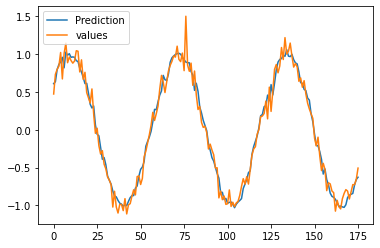

In [ ]:

plt.plot(pred,label="Prediction")
plt.plot(test_y,label="values")
plt.legend()
plt.show()




## Task: plot the prediction residual.
To actually detect the anomalies, we need to calculate the residual.
- Calculate the residual and plot it.
4. Does the residual look useful for detecting anomalies?
- Check if the injected anomaly can be detected using your residual score without giving any false positives

## Answer
- Yes. The anomaly is very easy to spot and detect.

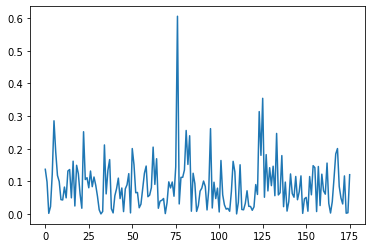

mean= 0.08914474307460835
std= 0.07786087027533277
OUTLIER: 1.5, index=76 , error=0.6055847622043048


In [ ]:
#residual = np.sqrt((pred-test_y)**2)
#residual = (pred-test_y)**2
residual = abs(pred-test_y)

plt.plot(residual)
plt.show()

mean = np.mean(residual)
std = np.std(residual)

print("mean=",mean)
print("std=",std)

for i,e in enumerate(residual):
  if(e > mean+(4*std)):
    print(f'OUTLIER: {test_y[i]}, index={i} , error={e}' )

# 4. Autoencoder for Anomaly Detection
Lastly, we will use an autoencoder on the same temporal dataset to detect anomalies. Although we will use it now in a temporal setting, note that autoencoders can also be used to detect anomalies in non-temporal data.

In [ ]:
import torch

## Task: Create train / test dataset
We will use the autoencoder slightly differently. Let's pretend that this dataset is the temperature at our nuclear reactor. We take a measurement every hour and we upload this data once per day to our server, at which point we use the autoencoder to detect anomalies.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take a window of 24 datapoints and reconstruct it. The stride should be 24.

In [ ]:
train_x = train[:(len(train)//24)*24].reshape(len(train)//24,24)
test_x = test[:(len(test)//24)*24].reshape(len(test)//24,24)

print(train_x.shape)
print(test_x.shape)

(33, 24)
(8, 24)


## Task: Train the autoencoder
Below I have provided a simple autoencoder class which you can use.
- Use the MSE loss and the Adam optimizer to train an autoencoder on the training dataset you created.

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_nodes):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(24, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, latent_nodes)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_nodes, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 24)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder(4)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# TODO: training loop

loss_data=[]
epochs=20
model.train()
for epoch in range(epochs):
  for i,data in enumerate((torch.from_numpy(train_x).float())):
    #print(data[0])
    #print(data[0].type())
    #print(data.shape)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, data.float())
    loss_data.append(loss.item())

    loss.backward()
    optimizer.step()
  print(f'epoch:{epoch}  loss:{loss}')



epoch:0  loss:0.32231423258781433
epoch:1  loss:0.1924017071723938
epoch:2  loss:0.04483749344944954
epoch:3  loss:0.013499236665666103
epoch:4  loss:0.012193134985864162
epoch:5  loss:0.017029376700520515
epoch:6  loss:0.02690453827381134
epoch:7  loss:0.018285168334841728
epoch:8  loss:0.030560806393623352
epoch:9  loss:0.008766601793467999
epoch:10  loss:0.008543341420590878
epoch:11  loss:0.010394773446023464
epoch:12  loss:0.017976250499486923
epoch:13  loss:0.014006140641868114
epoch:14  loss:0.020508531481027603
epoch:15  loss:0.01188762579113245
epoch:16  loss:0.016990667209029198
epoch:17  loss:0.014053436927497387
epoch:18  loss:0.01109581533819437
epoch:19  loss:0.008702083490788937


## Task: Plotting
Once you have achieved a loss you are happy with (should be below or around 0.02), apply the autoencoder to the test dataset and plot the reconstructed data.
Next, plot the reconstruction error on the test dataset.
1. Is the reconstruction error useful to detect the anomaly?
2. Which approach do you prefer for temporal data: to use ML to predict next values, or to use an autoencoder to reconstruct the data? Why?
3. There are a couple of hyperparameters which you had to figure out to train an accurate model (number of nodes in latent space, learning rate, number of epochs). Describe how the number of nodes in the autoencoder affects the performance of the model using plots.

## Answer
- 1. Yes, very useful

- 2. Autoencoder is cool

- 3.

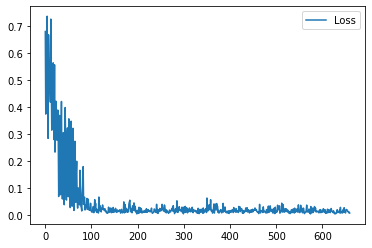

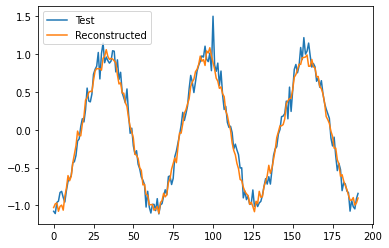

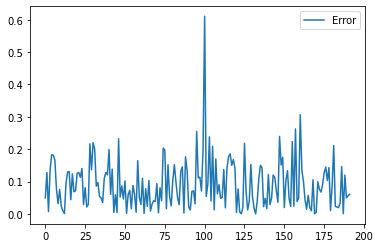

mean= 0.08965756576248134
std= 0.07600622566623853
OUTLIER: 1.5, index=100 , error=0.6106047630310059


In [ ]:

plt.plot(loss_data,label="Loss")
plt.legend()
plt.show()

model.eval()
#predictions=[]
#for i,data in enumerate((torch.from_numpy(test_x).float())):
with torch.no_grad():
  predictions=model(torch.from_numpy(test_x).float())


plt.plot(test_x.flatten(),label="Test")
plt.plot(predictions.flatten(),label="Reconstructed")
plt.legend()
plt.show()

error= abs((predictions.flatten()-test_x.flatten()).numpy())
plt.plot(error,label="Error")

plt.legend()
plt.show()

mean = np.mean(error)
std = np.std(error)

print("mean=",mean)
print("std=",std)

for i,e in enumerate(error):
  if(e > mean+(4*std)):
    print(f'OUTLIER: {test_x.flatten()[i]}, index={i} , error={e}' )

